In [18]:
library(lme4)
library(simr)
library(dplyr)
library(lmerTest)
library(ggplot2)
library(sjPlot)


In [7]:
# install.packages("car")
library(car)

In [8]:
file_path <- "pilot_TOTAL_TEST_merged.csv"

df <- read.csv(file_path) %>%
    select(it_sim_dis_diff, it_sim_dis_diff_sq, reliability, v2_sim_dis_diff, v2_sim_dis_diff_sq, participant, validity, resp_correct, Accuracy, validity_binary, reliability_binary, v2_sim_dis_attend, v2_sim_dis_attend_z, v2_sim_dis_attend_sq_z, it_sim_dis_attend, it_sim_dis_attend_z, it_sim_dis_attend_sq_z, v2_sim_dis_unattend, v2_sim_dis_unattend_z, v2_sim_dis_unattend_sq_z, it_sim_dis_unattend, it_sim_dis_unattend_z, it_sim_dis_unattend_sq_z, it_sim_dis_diff_z, v2_sim_dis_diff_z,it_sim_dis_diff_sq_z, v2_sim_dis_diff_sq_z, v2_sim_dis_test_z, it_sim_dis_test_z, it_sim_dis_diff_test, it_sim_dis_diff_test_sq, v2_sim_dis_diff_test, v2_sim_dis_diff_test_z,it_sim_dis_diff_test_z, v2_sim_dis_diff_test_sq_z, it_sim_dis_diff_test_sq_z, it_sim_dis_test_sq_z, validity_binary_z, reliability_binary_z, v2_sim_dis_test_sq_z, rt,tested_memorability_resmem_z, v2_pos_neg_abs_z, it_pos_neg_abs_z, it_pos_neg_z, v2_pos_neg_z, it_sim_dis_diff_test_sign_z, it_sim_dis_diff_test_sign_sq_z,v2_sim_dis_diff_test_sign_z, v2_sim_dis_diff_test_sign_sq_z, it_sim_dis_test_sign_z, it_sim_dis_test_sign_sq_z,v2_sim_dis_test_sign_z, v2_sim_dis_test_sign_sq_z, it_int_abs, v2_int_abs, it_int_rel, v2_int_rel, it_int_rel_sq, v2_int_rel_sq, it_int_abs, v2_int_abs, it_int_abs_sq, v2_int_abs_sq, it_pos_neg_abs, v2_pos_neg_abs, it_pos_neg, v2_pos_neg, vviq_sum)









In [9]:
control <- lmerControl(optimizer = "bobyqa")#, optCtrl = list(maxfun = 10000))

In [10]:
df_correct <- subset(df, resp_correct == 1)
# 

In [6]:
# names(df)


In [7]:
# mean(df$it_sim_dis_diff)


In [8]:
# model <- glm(
#   resp_correct ~ it_sim_dis_diff_test_z * reliability_binary * validity_binary + 
#              v2_sim_dis_diff_test_z * reliability_binary * validity_binary,
#   data = df,
#   family = binomial(link = "logit")
# )

# # View the model summary
# summary(model)

In [9]:
# # head(df$v2_sim_dis_test_z)



# formula1 <- glmer(resp_correct ~  v2_sim_dis_test_z * reliability_binary * validity_binary +  
#                    it_sim_dis_test_z * reliability_binary * validity_binary + (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))
# summary(formula1)

In [10]:
# model <- glm(
#   resp_correct ~ reliability_binary * validity_binary + (1 | participant),
#              y,
#   data = df,
#   family = binomial(link = "logit")
# )

# # View the model summary
# summary(model)

In [11]:
# # IT*V2*reliability*validity + itsq+v2sq



# formula1 <- glmer(resp_correct ~ it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z * reliability_binary * validity_binary +  
#                    v2_sim_dis_diff_test_sq_z + it_sim_dis_diff_test_sq_z + (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))


In [28]:
create_forest_plot_updated <- function(model, title = "Coefficient Forest Plot", 
                               sig_level = 0.05, pos_color = "green4", 
                               neg_color = "red3", nonsig_color = "black") {
  library(ggplot2)
  library(dplyr)
  
  # Get model summary
  model_summary <- summary(model)
  
  # Check if the model is lmer or glmer and extract coefficients accordingly
  if ("coefficients" %in% names(model_summary)) {
    coefs <- model_summary$coefficients
  } else if ("coef" %in% names(model_summary)) {
    # Some models might use 'coef' instead of 'coefficients'
    coefs <- model_summary$coef
  } else {
    stop("Could not extract coefficients from the model summary")
  }
  
  coef_names <- rownames(coefs)
  
  # Get the correct column index for p-values
  # lmer models typically have p-values in different columns than glmer
  if (ncol(coefs) >= 5) { # lmer often includes "df" and p-values are column 5
    p_val_col <- 5
  } else { # glmer typically has p-values in column 4
    p_val_col <- 4
  }
  
  # Create a data frame with all the necessary information
  coef_data <- data.frame(
    term = coef_names,
    estimate = coefs[, 1],      # First column contains estimates
    std.error = coefs[, 2],     # Second column contains std errors
    p.value = coefs[, p_val_col] # p-values column
  )
  
  # If p-values are not available (sometimes happens with lmer), calculate them
  if (!("p.value" %in% colnames(coef_data)) || all(is.na(coef_data$p.value))) {
    coef_data$p.value <- 2 * (1 - pnorm(abs(coef_data$estimate / coef_data$std.error)))
  }
  
  # Calculate confidence intervals manually
  coef_data <- coef_data %>%
    mutate(
      conf.low = estimate - 1.96 * std.error,
      conf.high = estimate + 1.96 * std.error,
      # Color based on significance and direction
      color = case_when(
        p.value < sig_level & estimate > 0 ~ pos_color,
        p.value < sig_level & estimate < 0 ~ neg_color,
        TRUE ~ nonsig_color
      )
    )
  
  # Create the forest plot
  p <- ggplot(coef_data, aes(x = estimate, y = term)) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
    geom_point(aes(color = color), size = 3) +
    scale_color_identity() +
    labs(
      title = title,
      x = "Estimate",
      y = "Term"
    ) +
    theme_bw() +
    theme(
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 14),
      plot.title = element_text(size = 16, face = "bold")
    )
  
  return(p)
}

In [14]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * vviq_sum * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) * vviq_sum *  reliability_binary_z *  
                  validity_binary_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)

Warning message in commonArgs(par, fn, control, environment()):
“maxfun < 10 * length(par)^2 is not recommended.”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.3193 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 40 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * vviq_sum *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_test_z +  
    v2_sim_dis_test_sq_z) * vviq_sum * reliability_binary_z *  
    validity_binary_z + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 63636.0  64006.5 -31777.0  63554.0    62059 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0424  0.2338  0.4373  0.5605  1.7113 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4636   0.6809  
Number of obs: 62100, groups:  participant, 205

Fixed effects:
                                                                       Estimate
(Intercept)                                                           1.569e+00
it_sim_dis_test_z                       

In [26]:
create_forest_plot <- function(model, title = "Coefficient Forest Plot of GLMER Model") {
  library(ggplot2)
  library(dplyr)
  
  # Get model summary
  model_summary <- summary(model)
  coefs <- model_summary$coefficients
  coef_names <- rownames(coefs)
  
  # Create a data frame with all the necessary information
  coef_data <- data.frame(
    term = coef_names,
    estimate = coefs[, 1],    # First column contains estimates
    std.error = coefs[, 2],   # Second column contains std errors
    p.value = coefs[, 4]      # Fourth column typically contains p-values
  )
  
  # Calculate confidence intervals manually
  coef_data <- coef_data %>%
    mutate(
      conf.low = estimate - 1.96 * std.error,
      conf.high = estimate + 1.96 * std.error,
      # Color based on significance and direction
      color = case_when(
        p.value < 0.05 & estimate > 0 ~ "green4",
        p.value < 0.05 & estimate < 0 ~ "red3",
        TRUE ~ "black"
      )
    )
  
  # Create the forest plot
  p <- ggplot(coef_data, aes(x = estimate, y = term)) +
    geom_vline(xintercept = 0, linetype = "dashed", color = "gray50") +
    geom_errorbarh(aes(xmin = conf.low, xmax = conf.high), height = 0.2) +
    geom_point(aes(color = color), size = 3) +
    scale_color_identity() +
    labs(
      title = title,
      x = "Estimate",
      y = "Term"
    ) +
    theme_bw() +
    theme(
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 14),
      plot.title = element_text(size = 16, face = "bold")
    )
  
  return(p)
}

forest_plot1 <- create_forest_plot(formula1, "Model 1: Effect on Accuracy")
# print(forest_plot1)

In [33]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)

Warning message in commonArgs(par, fn, control, environment()):
“maxfun < 10 * length(par)^2 is not recommended.”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.787738 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 41 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) *  
    vviq_sum * reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_z +  
    v2_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
    validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 63592.0  63971.6 -31754.0  63508.0    62058 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1312  0.2325  0.4363  0.5605  1.7066 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4647   0.6817  
Number of obs: 62100, groups:  participant, 205

Fixed effects:
                                                                            Estimate
(Intercept)                             

In [25]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * vviq_sum *  reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) * vviq_sum *  reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)

Warning message in commonArgs(par, fn, control, environment()):
“maxfun < 10 * length(par)^2 is not recommended.”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.787738 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 41 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) *  
    vviq_sum * reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_z +  
    v2_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
    validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 63592.0  63971.6 -31754.0  63508.0    62058 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1312  0.2325  0.4363  0.5605  1.7066 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4647   0.6817  
Number of obs: 62100, groups:  participant, 205

Fixed effects:
                                                                            Estimate
(Intercept)                             

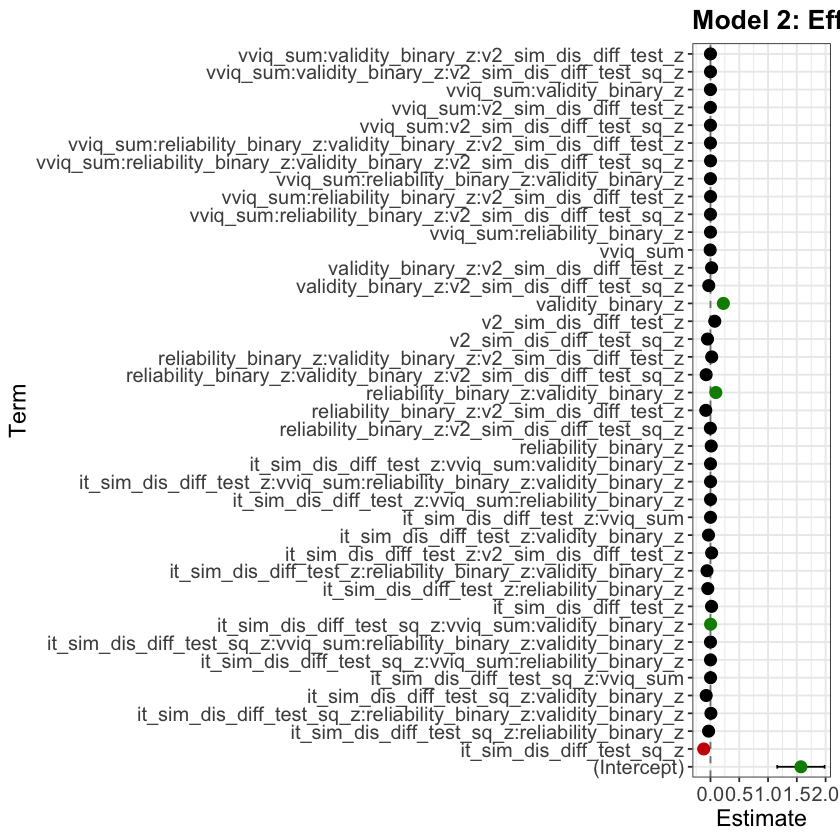

In [34]:
forest_plot2 <- create_forest_plot_updated(formula1, "Model 2: Effect on Accuracy - Relative")
forest_plot2


In [ ]:
forest_plot2 <- create_forest_plot(formula1, "Model 2: Effect on Accuracy - Relative")
print(forest_plot2)


Correlation matrix not shown by default, as p = 40 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * vviq_sum *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_test_z +  
    v2_sim_dis_test_sq_z) * vviq_sum * reliability_binary_z *  
    validity_binary_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 62564.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3606 -0.7382 -0.1687  0.5694  3.9707 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03541  0.1882  
 Residual                0.21469  0.4633  
Number of obs: 47213, groups:  participant, 205

Fixed effects:
                                                                       Estimate
(Intercept)                                                           1.535e+00
it_sim_dis_test_z                                                    -1.396e-02
it_sim_dis_

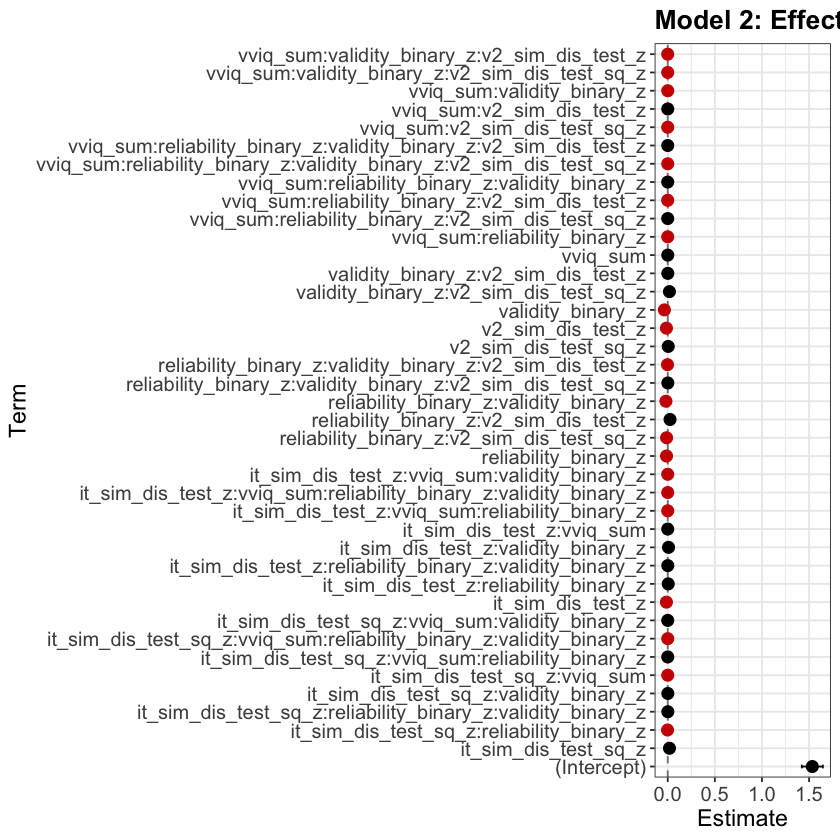

In [27]:
formula_rt1 <- lmer(rt ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * vviq_sum* reliability_binary_z *  
                validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) * vviq_sum* reliability_binary_z *  
                validity_binary_z + (1 | participant), 
                data = df_correct, control = lmerControl(optimizer = "bobyqa"))
summary(formula_rt1)  # Will now include p-values
# forest_plot3 <- create_forest_plot(formula_rt1, "Model 2: Effect on Accuracy - Relative")
# print(forest_plot3)


In [ ]:

# formula10 <- glmer(resp_correct ~ (it_sim_dis_diff_z + it_sim_dis_diff_sq_z) * vviq_sum* reliability_binary_z *  
#                   validity_binary_z + (v2_sim_dis_diff_z + v2_sim_dis_diff_sq_z) * vviq_sum* reliability_binary_z *  
#                   validity_binary_z + it_sim_dis_diff_z * v2_sim_dis_diff_z +  (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))
# summary(formula10)

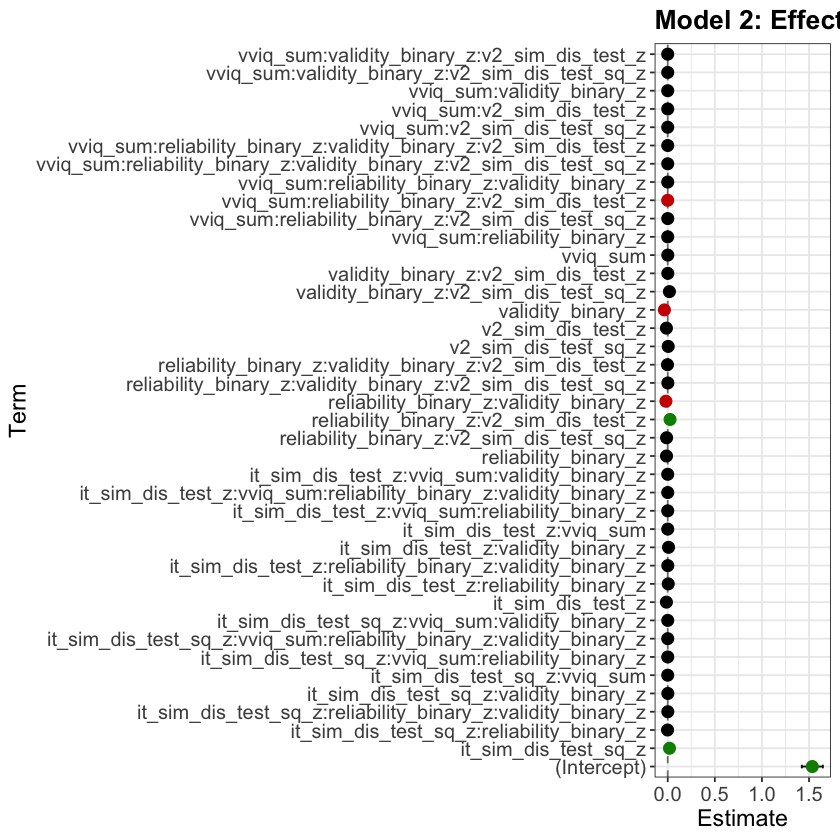

In [29]:
forest_plot3 <- create_forest_plot_updated(formula_rt1, "Model 2: Effect on Accuracy - Relative")
forest_plot3



In [31]:
formula_rt2 <- lmer(rt ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * vviq_sum* reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))

summary(formula_rt2)



Correlation matrix not shown by default, as p = 41 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * vviq_sum *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_z +  
    v2_sim_dis_diff_test_sq_z) * vviq_sum * reliability_binary_z *  
    validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z +  
    (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 62554.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3935 -0.7364 -0.1686  0.5711  3.9802 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03548  0.1884  
 Residual                0.21459  0.4632  
Number of obs: 47213, groups:  participant, 205

Fixed effects:
                                                                            Estimate
(Intercept)                                                                1.536e+00
it_s

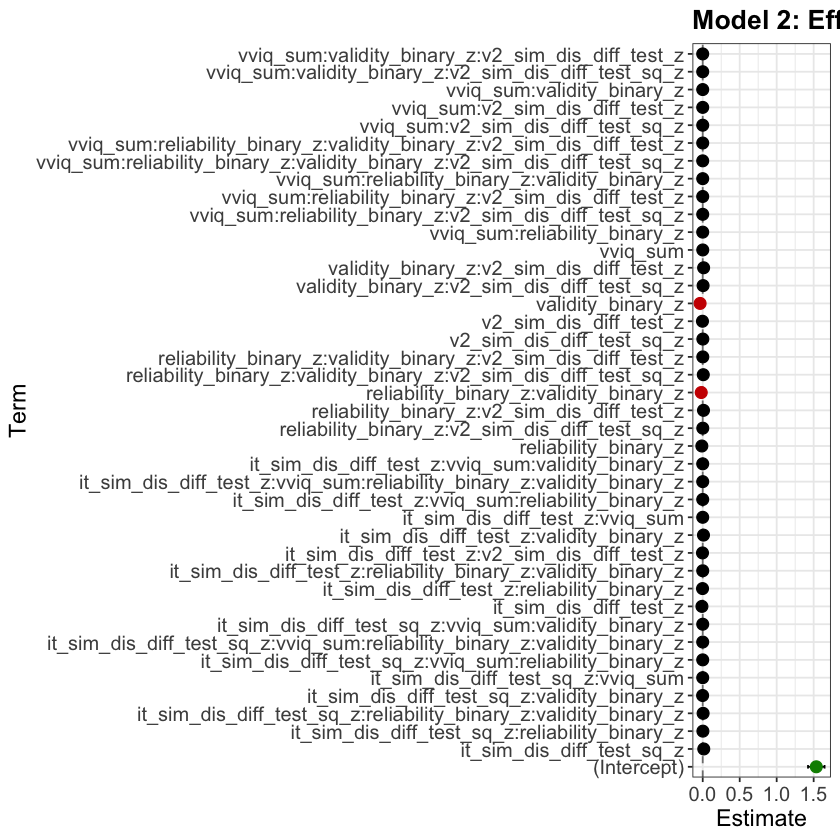

In [32]:
forest_plot4 <- create_forest_plot_updated(formula_rt2, "Model 2: Effect on Accuracy - Relative")
forest_plot4

In [20]:

# formula_rt4 <- lmer(rt ~ (it_sim_dis_diff_z + it_sim_dis_diff_sq_z) * reliability_binary_z *  
#                   validity_binary_z + (v2_sim_dis_diff_z + v2_sim_dis_diff_sq_z) * reliability_binary_z *  
#                   validity_binary_z + it_sim_dis_diff_z * v2_sim_dis_diff_z +  (1 | participant), 
#                   data = df_correct, control = lmerControl(optimizer = "bobyqa"))
# summary(formula_rt4)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_diff_z + it_sim_dis_diff_sq_z) * reliability_binary_z *  
    validity_binary_z + (v2_sim_dis_diff_z + v2_sim_dis_diff_sq_z) *  
    reliability_binary_z * validity_binary_z + it_sim_dis_diff_z *  
    v2_sim_dis_diff_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82242.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3612 -0.7362 -0.1693  0.5786  3.9374 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03512  0.1874  
 Residual                0.21907  0.4681  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                              Estimate
(Intercept)                                                  1.573e+00
it_sim_dis_diff_z                                           -6.419e-03
it_sim_dis_diff_sq_

In [21]:
formula_abs_cat_acc <- glmer(resp_correct ~ it_pos_neg_abs_z * reliability_binary_z *  
                  validity_binary_z + v2_pos_neg_abs_z * reliability_binary_z *  
                  validity_binary_z + it_pos_neg_z * v2_pos_neg_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula_abs_cat_acc)


Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ it_pos_neg_abs_z * reliability_binary_z * validity_binary_z +  
    v2_pos_neg_abs_z * reliability_binary_z * validity_binary_z +  
    it_pos_neg_z * v2_pos_neg_z + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87075.5  87224.6 -43521.7  87043.5    82484 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0040 -0.7714  0.4431  0.5870  1.6067 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4735   0.6881  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                         Estimate Std. Error
(Intercept)                                              1.181679   0.042779
it_pos_neg_abs_z                                         0.016481   0.014770
reliability_binary_

In [22]:
formula_rel_cat_acc <- glmer(resp_correct ~ it_pos_neg_z * reliability_binary_z *  
                  validity_binary_z + v2_pos_neg_z * reliability_binary_z *  
                  validity_binary_z + it_pos_neg_z * v2_pos_neg_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula_rel_cat_acc)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ it_pos_neg_z * reliability_binary_z * validity_binary_z +  
    v2_pos_neg_z * reliability_binary_z * validity_binary_z +  
    it_pos_neg_z * v2_pos_neg_z + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87077.3  87207.8 -43524.6  87049.3    82486 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9351 -0.7698  0.4435  0.5873  1.5773 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4736   0.6882  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                     Estimate Std. Error
(Intercept)                                          1.181301   0.042750
it_pos_neg_z                                         0.052214   0.008538
reliability_binary_z                   

In [23]:
formula_abs_cat_rt <- lmer(rt ~ it_pos_neg_abs_z * reliability_binary_z *  
                validity_binary_z + v2_pos_neg_abs_z * reliability_binary_z *  
                validity_binary_z + it_pos_neg_z * v2_pos_neg_z + (1 | participant), 
                data = df_correct, control = lmerControl(optimizer = "bobyqa"))
summary(formula_abs_cat_rt)  # Will now include p-values



Correlation matrix not shown by default, as p = 15 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ it_pos_neg_abs_z * reliability_binary_z * validity_binary_z +  
    v2_pos_neg_abs_z * reliability_binary_z * validity_binary_z +  
    it_pos_neg_z * v2_pos_neg_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82249.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3500 -0.7370 -0.1695  0.5790  3.8938 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03508  0.1873  
 Residual                0.21931  0.4683  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                          Estimate Std. Error
(Intercept)                                              1.572e+00  1.155e-02
it_pos_neg_abs_z                                        -6.246e-03  3.344e-03
reliability_binary_z                                    -1.724e-02 

In [24]:
formula_rel_cat_rt <- lmer(rt ~ it_pos_neg_z * reliability_binary_z *  
                  validity_binary_z + v2_pos_neg_z * reliability_binary_z *  
                  validity_binary_z + it_pos_neg_z * v2_pos_neg_z + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))

summary(formula_rel_cat_rt)


Correlation matrix not shown by default, as p = 13 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ it_pos_neg_z * reliability_binary_z * validity_binary_z +  
    v2_pos_neg_z * reliability_binary_z * validity_binary_z +  
    it_pos_neg_z * v2_pos_neg_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82241.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3485 -0.7370 -0.1693  0.5797  3.8969 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.0351   0.1873  
 Residual                0.2193   0.4683  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                      Estimate Std. Error
(Intercept)                                          1.572e+00  1.155e-02
it_pos_neg_z                                        -1.413e-02  1.948e-03
reliability_binary_z                                -1.724e-02  1.943e-03
validity_bina

In [25]:
# tested_memorability_resmem_z

In [26]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + tested_memorability_resmem_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * reliability_binary_z *  
    validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) *  
    reliability_binary_z * validity_binary_z + tested_memorability_resmem_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 86780.6  86985.6 -43368.3  86736.6    82478 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1073 -0.7479  0.4392  0.5851  1.7939 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4779   0.6913  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                              Estimate
(Intercept)                                                  1.1864292
it_sim_dis_test_z                                

In [27]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + tested_memorability_resmem_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 22 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_z +  
    v2_sim_dis_diff_test_sq_z) * reliability_binary_z * validity_binary_z +  
    it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + tested_memorability_resmem_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 86737.0  86951.3 -43345.5  86691.0    82477 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2328 -0.7457  0.4392  0.5851  1.8147 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4783   0.6916  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                                   Estimate
(Intercept)                             

In [28]:
formula_rt1 <- lmer(rt ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * reliability_binary_z *  
                validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) * reliability_binary_z *  
                validity_binary_z + tested_memorability_resmem_z + (1 | participant), 
                data = df_correct, control = lmerControl(optimizer = "bobyqa"))
summary(formula_rt1)  # Will now include p-values




Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_test_z + it_sim_dis_test_sq_z) * reliability_binary_z *  
    validity_binary_z + (v2_sim_dis_test_z + v2_sim_dis_test_sq_z) *  
    reliability_binary_z * validity_binary_z + tested_memorability_resmem_z +  
    (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82008.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3400 -0.7363 -0.1702  0.5767  3.9775 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03517  0.1875  
 Residual                0.21824  0.4672  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                              Estimate
(Intercept)                                                  1.573e+00
it_sim_dis_test_z                                           -3.811e-03
it_sim_dis_test_sq_z        

In [29]:
formula_rt2 <- lmer(rt ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_z * v2_sim_dis_diff_test_z + tested_memorability_resmem_z + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))

summary(formula_rt2)




Correlation matrix not shown by default, as p = 22 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_diff_test_z + it_sim_dis_diff_test_sq_z) * reliability_binary_z *  
    validity_binary_z + (v2_sim_dis_diff_test_z + v2_sim_dis_diff_test_sq_z) *  
    reliability_binary_z * validity_binary_z + it_sim_dis_diff_test_z *  
    v2_sim_dis_diff_test_z + tested_memorability_resmem_z + (1 |  
    participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 81992

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3472 -0.7363 -0.1704  0.5774  3.9857 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03518  0.1876  
 Residual                0.21814  0.4671  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                                   Estimate
(Intercept)                                                       1.574e+00
it_sim_dis_diff

In [30]:
# EDITS

In [31]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 20 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_test_sign_z +  
    v2_sim_dis_test_sign_sq_z) * reliability_binary_z * validity_binary_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87105.2  87300.9 -43531.6  87063.2    82479 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9686 -0.7708  0.4445  0.5872  1.5634 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4738   0.6883  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                                   Estimate
(Intercept)                                                       1.1809100
it_sim_dis_test_sign_z                             

In [32]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_sign_z + v2_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_sign_z * v2_sim_dis_diff_test_sign_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_sign_z +  
    v2_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
    validity_binary_z + it_sim_dis_diff_test_sign_z * v2_sim_dis_diff_test_sign_z +  
    (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87070.3  87275.4 -43513.2  87026.3    82478 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9688 -0.7702  0.4438  0.5869  1.6758 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4743   0.6887  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                                        Estimate
(Intercept)                        

In [33]:
formula_rt1 <- lmer(rt ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * reliability_binary_z *  
                validity_binary_z + (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) * reliability_binary_z *  
                validity_binary_z + (1 | participant), 
                data = df_correct, control = lmerControl(optimizer = "bobyqa"))
summary(formula_rt1) 


Correlation matrix not shown by default, as p = 20 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * reliability_binary_z *  
    validity_binary_z + (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) *  
    reliability_binary_z * validity_binary_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82295.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3780 -0.7375 -0.1680  0.5784  3.9175 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03513  0.1874  
 Residual                0.21931  0.4683  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                                   Estimate
(Intercept)                                                       1.572e+00
it_sim_dis_test_sign_z                                            1.503e-02
it_sim_dis_test_sign_sq_z     

In [34]:
formula_rt2 <- lmer(rt ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_sign_z + v2_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
                  validity_binary_z + it_sim_dis_diff_test_sign_z * v2_sim_dis_diff_test_sign_z  + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))


summary(formula_rt2)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_sign_z +  
    v2_sim_dis_diff_test_sign_sq_z) * reliability_binary_z *  
    validity_binary_z + it_sim_dis_diff_test_sign_z * v2_sim_dis_diff_test_sign_z +  
    (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82318.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3377 -0.7375 -0.1678  0.5777  3.8838 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03515  0.1875  
 Residual                0.21935  0.4683  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                                        Estimate
(Intercept)                                                            1.572e+00
it_si

In [35]:
### updated interaction terms 

In [36]:
formula1 <- glmer(resp_correct ~ (it_int_abs + it_int_abs_sq) * reliability_binary_z *  
                  validity_binary_z + (v2_int_abs + v2_int_abs_sq) * reliability_binary_z *  
                  validity_binary_z + it_int_abs * v2_int_abs + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_int_abs + it_int_abs_sq) * reliability_binary_z *  
    validity_binary_z + (v2_int_abs + v2_int_abs_sq) * reliability_binary_z *  
    validity_binary_z + it_int_abs * v2_int_abs + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87042.6  87247.6 -43499.3  86998.6    82478 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0462 -0.7711  0.4425  0.5866  1.5812 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4756   0.6897  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                       Estimate Std. Error
(Intercept)                                           1.1886598  0.0429190
it_int_abs                                            0.0466560  0.0088943
it_int

In [37]:
formula1 <- glmer(resp_correct ~ (it_int_rel + it_int_rel_sq) * reliability_binary_z *  
                  validity_binary_z + (v2_int_rel + v2_int_rel_sq) * reliability_binary_z *  
                  validity_binary_z + it_int_rel * v2_int_rel + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))

summary(formula1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_int_rel + it_int_rel_sq) * reliability_binary_z *  
    validity_binary_z + (v2_int_rel + v2_int_rel_sq) * reliability_binary_z *  
    validity_binary_z + it_int_rel * v2_int_rel + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa")

     AIC      BIC   logLik deviance df.resid 
 87052.0  87257.1 -43504.0  87008.0    82478 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.9636 -0.7684  0.4432  0.5864  1.6766 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4739   0.6884  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                      Estimate Std. Error
(Intercept)                                           1.179624   0.042780
it_int_rel                                            0.057041   0.008532
it_int_re

In [38]:
formula_rt1 <- lmer(rt ~ (it_int_abs + it_int_abs_sq) * reliability_binary_z *  
                  validity_binary_z + (v2_int_abs + v2_int_abs_sq) * reliability_binary_z *  
                  validity_binary_z + it_int_abs * v2_int_abs  + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))


summary(formula_rt1)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_int_abs + it_int_abs_sq) * reliability_binary_z * validity_binary_z +  
    (v2_int_abs + v2_int_abs_sq) * reliability_binary_z * validity_binary_z +  
    it_int_abs * v2_int_abs + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82315

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3294 -0.7364 -0.1679  0.5786  3.8712 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03515  0.1875  
 Residual                0.21934  0.4683  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                       Estimate Std. Error
(Intercept)                                           1.572e+00  1.157e-02
it_int_abs                                           -1.656e-03  2.026e-03
it_int_abs_sq                                         8.9

In [39]:
formula_rt2 <- lmer(rt ~ (it_int_rel + it_int_rel_sq) * reliability_binary_z *  
                  validity_binary_z + (v2_int_rel + v2_int_rel_sq) * reliability_binary_z *  
                  validity_binary_z + it_int_rel * v2_int_rel  + (1 | participant), 
                  data = df_correct, control = lmerControl(optimizer = "bobyqa"))


summary(formula_rt2)


Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_int_rel + it_int_rel_sq) * reliability_binary_z * validity_binary_z +  
    (v2_int_rel + v2_int_rel_sq) * reliability_binary_z * validity_binary_z +  
    it_int_rel * v2_int_rel + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82361.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3706 -0.7363 -0.1712  0.5782  3.9297 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03513  0.1874  
 Residual                0.21950  0.4685  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                       Estimate Std. Error
(Intercept)                                           1.572e+00  1.156e-02
it_int_rel                                           -3.869e-03  1.948e-03
it_int_rel_sq                                         6

In [40]:
#explicitly adding the sign value

In [41]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * it_pos_neg_abs * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) * v2_pos_neg_abs * reliability_binary_z *  
                  validity_binary_z + (1 | participant), 
                  data = df, family = binomial, control = glmerControl(optimizer = "bobyqa",
                                        optCtrl = list(maxfun = 500000),
                                        calc.derivs = FALSE))

summary(formula1)


Correlation matrix not shown by default, as p = 44 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: resp_correct ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) *  
    it_pos_neg_abs * reliability_binary_z * validity_binary_z +  
    (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) * v2_pos_neg_abs *  
        reliability_binary_z * validity_binary_z + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 5e+05),  
    calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 87030.0  87449.4 -43470.0  86940.0    82455 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.0946 -0.7674  0.4422  0.5860  1.6854 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4755   0.6896  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                                                  Estimate
(Intercept)    

In [42]:
formula1 <- glmer(resp_correct ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) * it_pos_neg * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_sign_z + v2_sim_dis_diff_test_sign_sq_z) * v2_pos_neg * reliability_binary_z *  
                  validity_binary_z + (1 | participant), 
                  data = df, family = binomial,control = glmerControl(optimizer = "bobyqa",
                                        optCtrl = list(maxfun = 500000),
                                        calc.derivs = FALSE))

summary(formula1)


Correlation matrix not shown by default, as p = 44 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
resp_correct ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) *  
    it_pos_neg * reliability_binary_z * validity_binary_z + (v2_sim_dis_diff_test_sign_z +  
    v2_sim_dis_diff_test_sign_sq_z) * v2_pos_neg * reliability_binary_z *  
    validity_binary_z + (1 | participant)
   Data: df
Control: glmerControl(optimizer = "bobyqa", optCtrl = list(maxfun = 5e+05),  
    calc.derivs = FALSE)

     AIC      BIC   logLik deviance df.resid 
 86995.3  87414.7 -43452.6  86905.3    82455 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.2479 -0.7630  0.4422  0.5860  1.7590 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.4755   0.6896  
Number of obs: 82500, groups:  participant, 271

Fixed effects:
                                                                                   Estimate
(Inte

In [43]:
formula_rt1 <- lmer(rt ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * it_pos_neg_abs * reliability_binary_z *  
                validity_binary_z + (v2_sim_dis_test_sign_z + v2_sim_dis_test_sign_sq_z) * v2_pos_neg_abs * reliability_binary_z *  
                validity_binary_z + (1 | participant), 
                data = df_correct, control = lmerControl(optimizer = "bobyqa"))
summary(formula_rt1)


Correlation matrix not shown by default, as p = 44 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
rt ~ (it_sim_dis_test_sign_z + it_sim_dis_test_sign_sq_z) * it_pos_neg_abs *  
    reliability_binary_z * validity_binary_z + (v2_sim_dis_test_sign_z +  
    v2_sim_dis_test_sign_sq_z) * v2_pos_neg_abs * reliability_binary_z *  
    validity_binary_z + (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 82406

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3548 -0.7360 -0.1690  0.5767  3.9095 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.0351   0.1873  
 Residual                0.2189   0.4679  
Number of obs: 61437, groups:  participant, 271

Fixed effects:
                                                                                  Estimate
(Intercept)                                                                      1.569e+00
it_sim_dis_test_sign_z                

In [13]:
formula_rt2 <- lmer(rt ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) * vviq_sum * it_pos_neg  * reliability_binary_z *  
                  validity_binary_z + (v2_sim_dis_diff_test_sign_z + v2_sim_dis_diff_test_sign_sq_z)  *vviq_sum * v2_pos_neg * reliability_binary_z *  
                  validity_binary_z   + (1 | participant), 
                  data = df_correct, control =lmerControl(optimizer = "bobyqa"))



summary(formula_rt2)


Correlation matrix not shown by default, as p = 88 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: rt ~ (it_sim_dis_diff_test_sign_z + it_sim_dis_diff_test_sign_sq_z) *  
    vviq_sum * it_pos_neg * reliability_binary_z * validity_binary_z +  
    (v2_sim_dis_diff_test_sign_z + v2_sim_dis_diff_test_sign_sq_z) *  
        vviq_sum * v2_pos_neg * reliability_binary_z * validity_binary_z +  
    (1 | participant)
   Data: df_correct
Control: lmerControl(optimizer = "bobyqa")

REML criterion at convergence: 63118.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.3626 -0.7359 -0.1659  0.5697  3.9655 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.03549  0.1884  
 Residual                0.21457  0.4632  
Number of obs: 47213, groups:  participant, 205

Fixed effects:
                                                                                            Estimate
(Intercept)                                                               

In [45]:
# formula1 <- glmer(resp_correct ~ v2_sim_dis_diff *reliability_binary * validity_binary  + (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))
# summary(formula1)

In [46]:
# formula1 <- glmer(resp_correct ~ it_sim_dis_diff *reliability_binary * validity_binary  + (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))
# summary(formula1)

In [47]:

# formula10 <- glmer(resp_correct ~ (it_sim_dis_unattend_z + it_sim_dis_unattend_sq_z) * reliability_binary *  
#                   validity_binary + (v2_sim_dis_unattend_z + v2_sim_dis_unattend_sq_z) * reliability_binary *  
#                   validity_binary + (1 | participant), 
#                   data = df, family = binomial, control = glmerControl(optimizer = "bobyqa"))
# summary(formula10)